# Sutton Chapter 12: Eligibility Traces

## 12.1 The λ-return with Example 6.2

In [1]:
import random

class RandomWalk:
    def __init__(self, size):
        self.size = size
        self.start = size // 2 + 1
        self.state = self.start
    
    def reset(self):
        self.state = self.start
        return self.state
    
    def step(self):
        """Simulate single step of random walk MRP.
        Returns state, reward, done.
        """
        direction = random.choice([-1, 1])
        self.state += direction
        
        if self.state == 0:
            return self.state, -1, True
        elif self.state == self.size + 1:
            return self.state, +1, True
        else:
            return self.state, 0, False

In [2]:
size = 19
env = RandomWalk(size)

def simulate_episode(env):
    state = env.reset()
    states = [state]
    rewards = []
    
    while True:
        state, reward, done = env.step()
        states.append(state)
        rewards.append(reward)
        
        if done:
            break
    
    return states, rewards

In [20]:
import numpy as np

# iterative policy evaluation as baseline for comparison
actual_state_values = (size + 2) * [0]
is_stable = False

while not is_stable:
    is_stable = True
    
    for state in range(1, size + 1):
        def r(other_state):
            if other_state == 0:
                return -1
            elif other_state == size + 1:
                return 1
            else:
                return 0
            
        new_state_value = 0.5 * (r(state - 1) + actual_state_values[state - 1]) + 0.5 * (r(state + 1) + actual_state_values[state + 1])
        
        if count % 1000 == 999:
            print(abs(new_state_value - actual_state_values[state]))
        
        if abs(new_state_value - actual_state_values[state]) > 1e-5:
            is_stable = False
            actual_state_values[state] = new_state_value

In [27]:
from math import sqrt

def rms_error(state_values):
    return sqrt(sum([
        (state_values[state] - actual_state_values[state]) ** 2
        for state in range(1, size + 1)
    ]))

In [30]:
state_values = (size + 2) * [0]

def lambda_return_episode(env, state_values, learning_rate, lambda_value):
    states, rewards = simulate_episode(env)
    T = len(rewards)
    
    # G_{t:t+n} in Sutton
    def n_step_return(t, n):
        return sum(rewards[t:t + n]) + state_values[states[t + n]]
    
    # G_t in Sutton
    def total_return(t):
        return sum(rewards[t:])
    
    # G_t^λ in Sutton
    def lambda_return(t, lambda_value):
        v = (1 - lambda_value) * sum([
            lambda_value ** (n - 1) * n_step_return(t, n)
            for n in range(1, T - t)
        ]) + lambda_value ** (T - t - 1) * total_return(t)
        return v
    
    for t in range(T):
        state = states[t]
        state_values[state] = (1 - learning_rate) * state_values[state] + learning_rate * lambda_return(t, lambda_value)
        #state_values[state] = (1 - learning_rate) * state_values[state] + learning_rate * total_return(t)
    
    return state_values

def lambda_return(env, state_values, learning_rate, lambda_value, num_episodes = 10):
    rms_total = 0
    
    for epoch in range(num_episodes):
        state_values = lambda_return_episode(env, state_values, learning_rate, lambda_value)
        rms_total += rms_error(state_values)
    
    return state_values, rms_total / num_episodes

In [33]:
import numpy as np

lambda_value = .8
xs = np.arange(0, 1, 0.05)
ys = [lambda_return(env, (size + 2) * [0], learning_rate, lambda_value)[1] for learning_rate in xs]

for j in range(len(xs)):
    learning_rate = xs[j]
    ys[j] = np.mean([lambda_return(env, (size + 2) * [0], learning_rate, lambda_value)[1] for _ in range(10)])

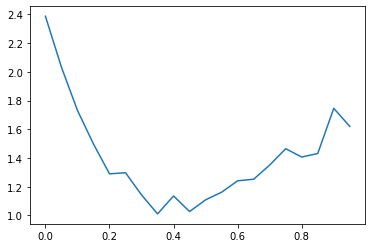

In [34]:
import matplotlib.pyplot as plt
plt.plot(xs, ys)

## 12.2 TD(λ)

In [55]:
import numpy as np

def td_lambda_episode(env, state_values, learning_rate, trace_decay):
    state_values = np.array(state_values)
    state = env.reset()
    d = len(state_values)
    z = np.zeros(d)
    
    while True:
        new_state, reward, done = env.step()
        v_grad = np.zeros(d)
        v_grad[state] = 1
        z = trace_decay * z + v_grad
        td_error = reward + state_values[new_state] - state_values[state]
        state_values += learning_rate * td_error * z
        state = new_state
        
        if done:
            break
    
    return state_values

def td_lambda(env, state_values, learning_rate, trace_decay, num_episodes=10):
    for epoch in range(num_episodes):
        state_values = td_lambda_episode(env, state_values, learning_rate, trace_decay)
    
    return state_values

### Comparison

In [65]:
%timeit state_values = lambda_return(env, np.zeros(size + 2), .4, .8, num_episodes=10)
print(rms_error(state_values))

104 ms ± 8.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.2582135766162288


In [66]:
%timeit state_values = td_lambda(env, np.zeros(size + 2), .4, .8, num_episodes=100)
print(rms_error(state_values))

46.8 ms ± 763 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.2582135766162288
